## Changes in the DLinear 

shuffle_flag = True --> False for tersting 

shuffle_flag = True --> False for training 


model_name=DLinear --> Linear 

In dataloader: Dataset_ETT_hour(scale=True-->False)

AR: Scale->Predict->Unscale->MSE: 
Linear: Scale->Predict->Unscale->MSE: 

AR: Scale->Predict->MSE: 
Linear: Scale->Predict->MSE: 0.375

AR: No scaling-> Predict -> MSE 
Linear: No Scaling -> Predict-> MSE 

Make sure inputs are same. 

In [1]:
seq_len = 336 
border1s = [0, 12 * 30 * 24 - seq_len, 12 * 30 * 24 + 4 * 30 * 24 - seq_len]
border2s = [12 * 30 * 24, 12 * 30 * 24 + 4 * 30 * 24, 12 * 30 * 24 + 8 * 30 * 24]

In [2]:
border1s, border2s

([0, 8304, 11184], [8640, 11520, 14400])

In [85]:
import torch 
import neuralprophet
from neuralprophet import NeuralProphet, set_log_level
from neuralprophet import set_random_seed 
set_log_level("ERROR", "INFO")

import numpy as np
set_random_seed(0)
import pandas as pd
from sklearn.preprocessing import StandardScaler

import copy 

def MSE(g_truth, measured):
    n=len(g_truth)
    diff=g_truth-measured
    return np.sum(np.square(diff)) / n 
    
    

from sklearn.metrics import mean_absolute_percentage_error
def MAPE(g_truth, measured):
    return (mean_absolute_percentage_error(g_truth,measured))

def wMAPE(g_truth, measured):
    nR = np.sum( np.absolute (g_truth-measured ))
    dR = np.sum( np.absolute (g_truth) )
    return (nR/dR)


def getPercentagedataset(N,n=96):
    print ("N, n", N,n)
    return ((n)/N)

def readDataset(csvFilename=""):
    df = pd.read_csv(csvFilename)
    print ("shape of dataset: ", df.shape)
    return df 

def ScaleDataset(df, date, numericalCols ):
    df = copy.deepcopy(df)
    date = copy.deepcopy(date)
    numericalCols = copy.deepcopy(numericalCols)
    scaler = StandardScaler()
    # Fit the scaler to the data
    scaler.fit(df)
    # Transform the data using the scaler
    df = scaler.transform(df)
    df = pd.DataFrame(df)
    #df["date"] = date
    #numericalCols.append("date")
    numericalCols.insert(0,"date")
    print ("date: ", date.shape, "df: ",df.shape)

    df.insert(0,'date', date.tolist())
    print ("columns: " , df.columns)
    #print (df[1:2])
    df = df.set_axis(numericalCols, axis=1, inplace=False)

    return df



def prepareDataFrame(df):
    nrows_=df.shape[0]
    regions = list(df)[1:]
    df_global = pd.DataFrame()
    for col in regions:
        print (col)
        aux = df[["date", col]].copy(deep=True)  # select column associated with region
        aux = aux.iloc[:nrows_, :].copy(deep=True)  # selects data up to 26301 row (2004 to 2007 time stamps)
        aux = aux.rename(columns={col: "y"})  # rename column of data to 'y' which is compatible with Neural Prophet
        aux["ID"] = col
        df_global = pd.concat((df_global, aux))


    df_global.rename({"date":"ds"},
                 inplace=True,
                axis=1)
    return df_global

def train_test_split(df_global, nhorizion=96, valid_p_=-1):
    print ("percentage test: ", valid_p_)
    m = NeuralProphet(growth='off',
                  yearly_seasonality=False,
                  weekly_seasonality=False,
                  daily_seasonality=False,
                  n_lags=336,
                  learning_rate=0.005,
                  epochs=10,
                  batch_size=32,
                      normalize="off",
                      loss_func='MSE'
                     ) ## only AR-net 
    df_train, df_test = m.split_df(df_global, valid_p=valid_p_, local_split=True)
    print ("train, test shape: ",df_train.shape, df_test.shape)
    return (df_train, df_test)

def training(df_train, df_test, col=""):
    print ("initialising  neuralprophet model with n_lag=336, global trend and seasonal effect")
    #m = NeuralProphet(trend_global_local="global", season_global_local="global", n_lags=336)
    m = NeuralProphet(growth='off',
                  yearly_seasonality=False,
                  weekly_seasonality=False,
                  daily_seasonality=False,
                  n_lags=336,
                  learning_rate=0.005,
                  epochs=10,
                  batch_size=32,
                      normalize="off",
                      loss_func='MSE'
                     ) ## only AR-net 
    metrics = m.fit(df_train, freq='auto')

    def forecasting(m,df_test):
        future = m.make_future_dataframe(df_test, n_historic_predictions=True)
        print ("forecasting....")
        forecast = m.predict(future)
        forecast_=forecast[(forecast.ID=="OT")].dropna()
        mse_=MSE(forecast_.y.to_numpy(), forecast_.yhat1.to_numpy()) #, MAPE(forecast_.y.to_numpy(), forecast_.yhat1.to_numpy()), wMAPE(forecast_.y.to_numpy(), forecast_.yhat1.to_numpy())
        return (mse_,forecast_,forecast)
    mse_list=[]
    if  type(df_test) == list:
        print ("list")
        for idf in df_test:
            mse_ = forecasting(m,idf)
            mse_list.append(mse_)
        return (mse_list)    
    elif type(df_test) == pd.DataFrame:
        print ("dataframe")
        mse_ = forecasting(m,df_test)
        return (mse_)
    else: 
        print ("not a valid format for forecasting ")

    

def forecast( dataset_ = "ETTh1.csv",nhorizion=96):
    df=readDataset(dataset_)
    
    numericalCols = list(df)[1:] 
    df = ScaleDataset(df[numericalCols],df.date, numericalCols)

    ####valid_p_ = getPercentagedataset(len(df),nhorizion)
    df = prepareDataFrame(df)
    df_train,df_test = train_test_split(df, valid_p_=nhorizion) # valid_p can be kept as integer as well, note that test dataset will also have the past look up dataset, i.e. 338 in this case, so the total dataset size would be past look up + forecast horizion ; 338 + 96 
    mse_ = training(df_train,df_test)
    return mse_




In [86]:
#mse_etth1 = forecast(dataset_="dataset/ETTh1.csv",nhorizion=96)

In [5]:
#mse_etth1[0]

In [6]:
#mse_etth1[1]

In [7]:
#mse_nillness = forecast(dataset_="dataset/national_illness.csv")

In [8]:
#mse_nillness[0]

In [9]:
#mse_nillness[1].yhat1.plot()
#mse_nillness[1].y.plot()

In [10]:
#mse_exchange = forecast(dataset_="dataset/exchange_rate.csv")

In [11]:
#mse_exchange[0]

In [12]:
#mse_exchange[1].y.plot()
#mse_exchange[1].yhat1.plot()

In [13]:
#mse_etth2 = forecast(dataset_="dataset/ETTh2.csv",nhorizion=96)

In [14]:
#mse_etth2[0]

## Summary 
1. MSE metric from AR-Net is almost 100x better than Linear/DLinear model for all the dataset tested here. 
2. One drawback of using MSE for this comparison is normalising the dataest using standardscaler is square of a number <1. Square of a number b/w 0-1.0 will be even smaller hence the MSE will appear to be smaller however the difference in actual values might be large, so it has to be kept in mind. 

## Question:
1. Why does Linear perform so bad, check the AR-net hyperparameters etc, 
2. Can 2700 test samples be an issue? From preliminary test it does not seems to be the case. 
3. Why does the value of StandardScaler output not match in case of my setup and DLinear setup. 



In [94]:
dataset_ = "ETTh1.csv"
nhorizion=0.2
df=readDataset(dataset_)
df1 = df[border1s[0]:border2s[0]] ##  trainig set in DLinear 
df2 = df[border1s[2]:border2s[2]]  ## Test in DLinear ; not considering validation 
numericalCols = list(df)[1:] 
print ("numericalCols here: ",numericalCols)
#df_train = ScaleDataset(df1[numericalCols],df1.date, numericalCols)

numericalCols = list(df2)[1:]  ## this needs to be changed again as this is called in function
#df_test = ScaleDataset(df2[numericalCols],df2.date, numericalCols)
df_train=df1
df_test=df2
#df_train = prepareDataFrame(df_train)
#df_test = prepareDataFrame(df_test)

#df = ScaleDataset(df[numericalCols],df.date, numericalCols)
#df = prepareDataFrame(df)
#df_train,df_test = train_test_split(df, valid_p_=nhorizion) 

shape of dataset:  (17420, 8)
numericalCols here:  ['HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'OT']


In [108]:
df_train[8500:8550]

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
8500,2017-06-20 04:00:00,9.846,1.741,7.960,2.381,1.888,-0.701,17.868000
8501,2017-06-20 05:00:00,9.779,1.808,6.538,1.564,2.619,-0.609,18.290001
8502,2017-06-20 06:00:00,8.306,1.942,5.224,1.564,2.924,-0.426,18.993999
8503,2017-06-20 07:00:00,5.894,1.674,3.518,1.670,2.711,-0.396,19.416000
8504,2017-06-20 08:00:00,1.474,2.210,-0.888,2.274,2.711,-0.213,20.118999
8505,2017-06-20 09:00:00,-0.268,1.474,-3.625,2.132,3.290,-0.274,19.275000
8506,2017-06-20 10:00:00,0.536,2.210,-2.914,2.416,3.350,-0.457,20.190001
8507,2017-06-20 11:00:00,-6.765,3.550,-10.305,3.625,3.381,-0.548,21.245001
8508,2017-06-20 12:00:00,-13.262,3.349,-15.600,3.625,2.680,-0.579,21.808001
8509,2017-06-20 13:00:00,-4.287,2.210,-7.889,2.416,3.442,-0.335,21.878000


In [102]:
336*32

10752

In [104]:
df.tail(10)

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
17410,2018-06-26 10:00:00,-6.497,6.162,-10.483000,3.767,3.564,1.614,8.934
17411,2018-06-26 11:00:00,-10.449,5.090,-14.463000,3.198,3.442,1.340,9.215
17412,2018-06-26 12:00:00,-15.271,3.818,-17.554001,2.452,2.132,0.883,9.215
17413,2018-06-26 13:00:00,-6.229,3.483,-9.666000,1.528,3.137,1.310,9.426
17414,2018-06-26 14:00:00,-1.273,3.617,-4.904000,2.132,3.320,1.432,10.200
17415,2018-06-26 15:00:00,-1.674,3.550,-5.615000,2.132,3.472,1.523,10.904
17416,2018-06-26 16:00:00,-5.492,4.287,-9.132000,2.274,3.533,1.675,11.044
17417,2018-06-26 17:00:00,2.813,3.818,-0.817000,2.097,3.716,1.523,10.271
17418,2018-06-26 18:00:00,9.243,3.818,5.472000,2.097,3.655,1.432,9.778
17419,2018-06-26 19:00:00,10.114,3.550,6.183000,1.564,3.716,1.462,9.567


In [45]:
df_local = df_test[df_test.ID=="OT"]
n_test_size = df_local.shape[0]
categories = df_test.ID.unique().tolist()
sample_size = 336
horizion=96
samples=[]


for i in range(n_test_size):
    if i+sample_size+horizion>=n_test_size:
        break 
    
    nr = i,i+sample_size,i+sample_size+horizion
    samples.append(nr)
    

In [46]:
len(samples),n_test_size

(2784, 3216)

In [47]:
df_list=[]
for inr in samples: 
    df_list.append(df_local[inr[0]:inr[2]] )

In [48]:
#mse_ = training(df_train[df_train.ID=="HUFL"],df_list[0])
mse_ = training(df_train,df_list[0])


initialising  neuralprophet model with n_lag=336, global trend and seasonal effect


Training: 0it [00:00, ?it/s]

dataframe
forecasting....


Predicting: 1817it [00:00, ?it/s]

In [49]:
a=mse_[2].dropna()

In [50]:
a

,ds,y,ID,yhat1,ar1,trend
336,2017-10-24 00:00:00,9.215,OT,9.047210,9.039151,0.008059
337,2017-10-24 01:00:00,9.145,OT,9.314811,9.306752,0.008059
338,2017-10-24 02:00:00,9.497,OT,9.201284,9.193226,0.008059
339,2017-10-24 03:00:00,9.075,OT,9.213740,9.205682,0.008059
340,2017-10-24 04:00:00,8.723,OT,8.624977,8.616919,0.008059
...,...,...,...,...,...,...
427,2017-10-27 19:00:00,11.818,OT,11.301372,11.293313,0.008059
428,2017-10-27 20:00:00,11.678,OT,11.151881,11.143823,0.008059
429,2017-10-27 21:00:00,11.889,OT,11.016769,11.008711,0.008059
430,2017-10-27 22:00:00,11.326,OT,11.694853,11.686794,0.008059


In [51]:
MSE(a.y,a.yhat1)

0.2944013889160123

In [41]:
df_list[0]

,ds,y,ID
11184,2017-10-10 00:00:00,4.287,HULL
11185,2017-10-10 01:00:00,4.555,HULL
11186,2017-10-10 02:00:00,4.019,HULL
11187,2017-10-10 03:00:00,3.952,HULL
11188,2017-10-10 04:00:00,4.220,HULL
...,...,...,...
11611,2017-10-27 19:00:00,1.407,HULL
11612,2017-10-27 20:00:00,1.273,HULL
11613,2017-10-27 21:00:00,1.206,HULL
11614,2017-10-27 22:00:00,1.808,HULL


In [447]:
df_train[df_train.ID=="HUFL"]

,ds,y,ID
0,2016-07-01 00:00:00,-0.219049,HUFL
1,2016-07-01 01:00:00,-0.238009,HUFL
2,2016-07-01 02:00:00,-0.313849,HUFL
3,2016-07-01 03:00:00,-0.323329,HUFL
4,2016-07-01 04:00:00,-0.285409,HUFL
...,...,...,...
13999,2018-02-04 07:00:00,0.965662,HUFL
14000,2018-02-04 08:00:00,0.823463,HUFL
14001,2018-02-04 09:00:00,-1.053003,HUFL
14002,2018-02-04 10:00:00,-1.886956,HUFL


In [16]:
def GetStartPoint(df, cols):
    '''for a given ID, get the starting point in the dataframe'''
    idx=[]
    for icol in cols:
        df_tmp = df[df.ID==icol]
        idx.append(df_tmp.index[0])
    return idx


def plus1index(index):
    '''adding one to each of the element of the list'''
    return ((np.array(index)+1).tolist())
    


In [17]:
len(df_test)

22512

In [18]:
3216-336-96

2784

In [19]:
dd1,dd2=train_test_split(df_test, valid_p_=2784)

percentage test:  2784
train, test shape:  (3024, 3) (21840, 3)


In [20]:
mse_ = training(df_train,dd1)

initialising  neuralprophet model with n_lag=336, global trend and seasonal effect


Training: 0it [00:00, ?it/s]

dataframe
forecasting....


Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

Predicting: 1817it [00:00, ?it/s]

In [68]:
mse_[1]

,ds,y,ID,yhat1,ar1,trend
336,2017-10-24 00:00:00,9.215,OT,9.047210,9.039151,0.008059
337,2017-10-24 01:00:00,9.145,OT,9.314811,9.306752,0.008059
338,2017-10-24 02:00:00,9.497,OT,9.201284,9.193226,0.008059
339,2017-10-24 03:00:00,9.075,OT,9.213740,9.205682,0.008059
340,2017-10-24 04:00:00,8.723,OT,8.624977,8.616919,0.008059
...,...,...,...,...,...,...
427,2017-10-27 19:00:00,11.818,OT,11.301372,11.293313,0.008059
428,2017-10-27 20:00:00,11.678,OT,11.151881,11.143823,0.008059
429,2017-10-27 21:00:00,11.889,OT,11.016769,11.008711,0.008059
430,2017-10-27 22:00:00,11.326,OT,11.694853,11.686794,0.008059


(96,)

In [26]:
#imax= int(len(df_test)/nunique) - lookback  - horizion 
imax = len(df_test)
df_list=[]
index_=GetStartPoint(df_test, df_test.ID.unique().tolist())
index_



[11184, 11184, 11184, 11184, 11184, 11184, 11184]

In [27]:
df_local = df_test[df_test.ID=="HUFL"]
n_test_size = df_local.shape[0]
sample_size = 336
horizion=96
loopidx = n_test_size - sample_size - horizion ## [3216-336-96]

import copy
index1_= copy.copy(index_)
print (imax, index_[-1])
for i in range(imax):
    #if index_[-1]> (len(df_list)-432):
    if loopidx-i>1:
        df1,df2 = train_test_split(df_test, valid_p_=loopidx-i) 
        df_list.append(df1)
        df_test = df_test.drop(index=index_, axis=0)
        index_ = plus1index(index_)
        


22512 11184
percentage test:  2784
train, test shape:  (3024, 3) (21840, 3)
percentage test:  2783
train, test shape:  (3024, 3) (21833, 3)
percentage test:  2782
train, test shape:  (3024, 3) (21826, 3)
percentage test:  2781
train, test shape:  (3024, 3) (21819, 3)
percentage test:  2780
train, test shape:  (3024, 3) (21812, 3)
percentage test:  2779
train, test shape:  (3024, 3) (21805, 3)
percentage test:  2778
train, test shape:  (3024, 3) (21798, 3)
percentage test:  2777
train, test shape:  (3024, 3) (21791, 3)
percentage test:  2776
train, test shape:  (3024, 3) (21784, 3)
percentage test:  2775
train, test shape:  (3024, 3) (21777, 3)
percentage test:  2774
train, test shape:  (3024, 3) (21770, 3)
percentage test:  2773
train, test shape:  (3024, 3) (21763, 3)
percentage test:  2772
train, test shape:  (3024, 3) (21756, 3)
percentage test:  2771
train, test shape:  (3024, 3) (21749, 3)
percentage test:  2770
train, test shape:  (3024, 3) (21742, 3)
percentage test:  2769
train

train, test shape:  (3024, 3) (20930, 3)
percentage test:  2653
train, test shape:  (3024, 3) (20923, 3)
percentage test:  2652
train, test shape:  (3024, 3) (20916, 3)
percentage test:  2651
train, test shape:  (3024, 3) (20909, 3)
percentage test:  2650
train, test shape:  (3024, 3) (20902, 3)
percentage test:  2649
train, test shape:  (3024, 3) (20895, 3)
percentage test:  2648
train, test shape:  (3024, 3) (20888, 3)
percentage test:  2647
train, test shape:  (3024, 3) (20881, 3)
percentage test:  2646
train, test shape:  (3024, 3) (20874, 3)
percentage test:  2645
train, test shape:  (3024, 3) (20867, 3)
percentage test:  2644
train, test shape:  (3024, 3) (20860, 3)
percentage test:  2643
train, test shape:  (3024, 3) (20853, 3)
percentage test:  2642
train, test shape:  (3024, 3) (20846, 3)
percentage test:  2641
train, test shape:  (3024, 3) (20839, 3)
percentage test:  2640
train, test shape:  (3024, 3) (20832, 3)
percentage test:  2639
train, test shape:  (3024, 3) (20825, 3)

train, test shape:  (3024, 3) (20013, 3)
percentage test:  2522
train, test shape:  (3024, 3) (20006, 3)
percentage test:  2521
train, test shape:  (3024, 3) (19999, 3)
percentage test:  2520
train, test shape:  (3024, 3) (19992, 3)
percentage test:  2519
train, test shape:  (3024, 3) (19985, 3)
percentage test:  2518
train, test shape:  (3024, 3) (19978, 3)
percentage test:  2517
train, test shape:  (3024, 3) (19971, 3)
percentage test:  2516
train, test shape:  (3024, 3) (19964, 3)
percentage test:  2515
train, test shape:  (3024, 3) (19957, 3)
percentage test:  2514
train, test shape:  (3024, 3) (19950, 3)
percentage test:  2513
train, test shape:  (3024, 3) (19943, 3)
percentage test:  2512
train, test shape:  (3024, 3) (19936, 3)
percentage test:  2511
train, test shape:  (3024, 3) (19929, 3)
percentage test:  2510
train, test shape:  (3024, 3) (19922, 3)
percentage test:  2509
train, test shape:  (3024, 3) (19915, 3)
percentage test:  2508
train, test shape:  (3024, 3) (19908, 3)

train, test shape:  (3024, 3) (19110, 3)
percentage test:  2393
train, test shape:  (3024, 3) (19103, 3)
percentage test:  2392
train, test shape:  (3024, 3) (19096, 3)
percentage test:  2391
train, test shape:  (3024, 3) (19089, 3)
percentage test:  2390
train, test shape:  (3024, 3) (19082, 3)
percentage test:  2389
train, test shape:  (3024, 3) (19075, 3)
percentage test:  2388
train, test shape:  (3024, 3) (19068, 3)
percentage test:  2387
train, test shape:  (3024, 3) (19061, 3)
percentage test:  2386
train, test shape:  (3024, 3) (19054, 3)
percentage test:  2385
train, test shape:  (3024, 3) (19047, 3)
percentage test:  2384
train, test shape:  (3024, 3) (19040, 3)
percentage test:  2383
train, test shape:  (3024, 3) (19033, 3)
percentage test:  2382
train, test shape:  (3024, 3) (19026, 3)
percentage test:  2381
train, test shape:  (3024, 3) (19019, 3)
percentage test:  2380
train, test shape:  (3024, 3) (19012, 3)
percentage test:  2379
train, test shape:  (3024, 3) (19005, 3)

train, test shape:  (3024, 3) (18200, 3)
percentage test:  2263
train, test shape:  (3024, 3) (18193, 3)
percentage test:  2262
train, test shape:  (3024, 3) (18186, 3)
percentage test:  2261
train, test shape:  (3024, 3) (18179, 3)
percentage test:  2260
train, test shape:  (3024, 3) (18172, 3)
percentage test:  2259
train, test shape:  (3024, 3) (18165, 3)
percentage test:  2258
train, test shape:  (3024, 3) (18158, 3)
percentage test:  2257
train, test shape:  (3024, 3) (18151, 3)
percentage test:  2256
train, test shape:  (3024, 3) (18144, 3)
percentage test:  2255
train, test shape:  (3024, 3) (18137, 3)
percentage test:  2254
train, test shape:  (3024, 3) (18130, 3)
percentage test:  2253
train, test shape:  (3024, 3) (18123, 3)
percentage test:  2252
train, test shape:  (3024, 3) (18116, 3)
percentage test:  2251
train, test shape:  (3024, 3) (18109, 3)
percentage test:  2250
train, test shape:  (3024, 3) (18102, 3)
percentage test:  2249
train, test shape:  (3024, 3) (18095, 3)

train, test shape:  (3024, 3) (17297, 3)
percentage test:  2134
train, test shape:  (3024, 3) (17290, 3)
percentage test:  2133
train, test shape:  (3024, 3) (17283, 3)
percentage test:  2132
train, test shape:  (3024, 3) (17276, 3)
percentage test:  2131
train, test shape:  (3024, 3) (17269, 3)
percentage test:  2130
train, test shape:  (3024, 3) (17262, 3)
percentage test:  2129
train, test shape:  (3024, 3) (17255, 3)
percentage test:  2128
train, test shape:  (3024, 3) (17248, 3)
percentage test:  2127
train, test shape:  (3024, 3) (17241, 3)
percentage test:  2126
train, test shape:  (3024, 3) (17234, 3)
percentage test:  2125
train, test shape:  (3024, 3) (17227, 3)
percentage test:  2124
train, test shape:  (3024, 3) (17220, 3)
percentage test:  2123
train, test shape:  (3024, 3) (17213, 3)
percentage test:  2122
train, test shape:  (3024, 3) (17206, 3)
percentage test:  2121
train, test shape:  (3024, 3) (17199, 3)
percentage test:  2120
train, test shape:  (3024, 3) (17192, 3)

train, test shape:  (3024, 3) (16380, 3)
percentage test:  2003
train, test shape:  (3024, 3) (16373, 3)
percentage test:  2002
train, test shape:  (3024, 3) (16366, 3)
percentage test:  2001
train, test shape:  (3024, 3) (16359, 3)
percentage test:  2000
train, test shape:  (3024, 3) (16352, 3)
percentage test:  1999
train, test shape:  (3024, 3) (16345, 3)
percentage test:  1998
train, test shape:  (3024, 3) (16338, 3)
percentage test:  1997
train, test shape:  (3024, 3) (16331, 3)
percentage test:  1996
train, test shape:  (3024, 3) (16324, 3)
percentage test:  1995
train, test shape:  (3024, 3) (16317, 3)
percentage test:  1994
train, test shape:  (3024, 3) (16310, 3)
percentage test:  1993
train, test shape:  (3024, 3) (16303, 3)
percentage test:  1992
train, test shape:  (3024, 3) (16296, 3)
percentage test:  1991
train, test shape:  (3024, 3) (16289, 3)
percentage test:  1990
train, test shape:  (3024, 3) (16282, 3)
percentage test:  1989
train, test shape:  (3024, 3) (16275, 3)

train, test shape:  (3024, 3) (15477, 3)
percentage test:  1874
train, test shape:  (3024, 3) (15470, 3)
percentage test:  1873
train, test shape:  (3024, 3) (15463, 3)
percentage test:  1872
train, test shape:  (3024, 3) (15456, 3)
percentage test:  1871
train, test shape:  (3024, 3) (15449, 3)
percentage test:  1870
train, test shape:  (3024, 3) (15442, 3)
percentage test:  1869
train, test shape:  (3024, 3) (15435, 3)
percentage test:  1868
train, test shape:  (3024, 3) (15428, 3)
percentage test:  1867
train, test shape:  (3024, 3) (15421, 3)
percentage test:  1866
train, test shape:  (3024, 3) (15414, 3)
percentage test:  1865
train, test shape:  (3024, 3) (15407, 3)
percentage test:  1864
train, test shape:  (3024, 3) (15400, 3)
percentage test:  1863
train, test shape:  (3024, 3) (15393, 3)
percentage test:  1862
train, test shape:  (3024, 3) (15386, 3)
percentage test:  1861
train, test shape:  (3024, 3) (15379, 3)
percentage test:  1860
train, test shape:  (3024, 3) (15372, 3)

train, test shape:  (3024, 3) (14567, 3)
percentage test:  1744
train, test shape:  (3024, 3) (14560, 3)
percentage test:  1743
train, test shape:  (3024, 3) (14553, 3)
percentage test:  1742
train, test shape:  (3024, 3) (14546, 3)
percentage test:  1741
train, test shape:  (3024, 3) (14539, 3)
percentage test:  1740
train, test shape:  (3024, 3) (14532, 3)
percentage test:  1739
train, test shape:  (3024, 3) (14525, 3)
percentage test:  1738
train, test shape:  (3024, 3) (14518, 3)
percentage test:  1737
train, test shape:  (3024, 3) (14511, 3)
percentage test:  1736
train, test shape:  (3024, 3) (14504, 3)
percentage test:  1735
train, test shape:  (3024, 3) (14497, 3)
percentage test:  1734
train, test shape:  (3024, 3) (14490, 3)
percentage test:  1733
train, test shape:  (3024, 3) (14483, 3)
percentage test:  1732
train, test shape:  (3024, 3) (14476, 3)
percentage test:  1731
train, test shape:  (3024, 3) (14469, 3)
percentage test:  1730
train, test shape:  (3024, 3) (14462, 3)

train, test shape:  (3024, 3) (13643, 3)
percentage test:  1612
train, test shape:  (3024, 3) (13636, 3)
percentage test:  1611
train, test shape:  (3024, 3) (13629, 3)
percentage test:  1610
train, test shape:  (3024, 3) (13622, 3)
percentage test:  1609
train, test shape:  (3024, 3) (13615, 3)
percentage test:  1608
train, test shape:  (3024, 3) (13608, 3)
percentage test:  1607
train, test shape:  (3024, 3) (13601, 3)
percentage test:  1606
train, test shape:  (3024, 3) (13594, 3)
percentage test:  1605
train, test shape:  (3024, 3) (13587, 3)
percentage test:  1604
train, test shape:  (3024, 3) (13580, 3)
percentage test:  1603
train, test shape:  (3024, 3) (13573, 3)
percentage test:  1602
train, test shape:  (3024, 3) (13566, 3)
percentage test:  1601
train, test shape:  (3024, 3) (13559, 3)
percentage test:  1600
train, test shape:  (3024, 3) (13552, 3)
percentage test:  1599
train, test shape:  (3024, 3) (13545, 3)
percentage test:  1598
train, test shape:  (3024, 3) (13538, 3)

train, test shape:  (3024, 3) (12712, 3)
percentage test:  1479
train, test shape:  (3024, 3) (12705, 3)
percentage test:  1478
train, test shape:  (3024, 3) (12698, 3)
percentage test:  1477
train, test shape:  (3024, 3) (12691, 3)
percentage test:  1476
train, test shape:  (3024, 3) (12684, 3)
percentage test:  1475
train, test shape:  (3024, 3) (12677, 3)
percentage test:  1474
train, test shape:  (3024, 3) (12670, 3)
percentage test:  1473
train, test shape:  (3024, 3) (12663, 3)
percentage test:  1472
train, test shape:  (3024, 3) (12656, 3)
percentage test:  1471
train, test shape:  (3024, 3) (12649, 3)
percentage test:  1470
train, test shape:  (3024, 3) (12642, 3)
percentage test:  1469
train, test shape:  (3024, 3) (12635, 3)
percentage test:  1468
train, test shape:  (3024, 3) (12628, 3)
percentage test:  1467
train, test shape:  (3024, 3) (12621, 3)
percentage test:  1466
train, test shape:  (3024, 3) (12614, 3)
percentage test:  1465
train, test shape:  (3024, 3) (12607, 3)

train, test shape:  (3024, 3) (11795, 3)
percentage test:  1348
train, test shape:  (3024, 3) (11788, 3)
percentage test:  1347
train, test shape:  (3024, 3) (11781, 3)
percentage test:  1346
train, test shape:  (3024, 3) (11774, 3)
percentage test:  1345
train, test shape:  (3024, 3) (11767, 3)
percentage test:  1344
train, test shape:  (3024, 3) (11760, 3)
percentage test:  1343
train, test shape:  (3024, 3) (11753, 3)
percentage test:  1342
train, test shape:  (3024, 3) (11746, 3)
percentage test:  1341
train, test shape:  (3024, 3) (11739, 3)
percentage test:  1340
train, test shape:  (3024, 3) (11732, 3)
percentage test:  1339
train, test shape:  (3024, 3) (11725, 3)
percentage test:  1338
train, test shape:  (3024, 3) (11718, 3)
percentage test:  1337
train, test shape:  (3024, 3) (11711, 3)
percentage test:  1336
train, test shape:  (3024, 3) (11704, 3)
percentage test:  1335
train, test shape:  (3024, 3) (11697, 3)
percentage test:  1334
train, test shape:  (3024, 3) (11690, 3)

train, test shape:  (3024, 3) (10871, 3)
percentage test:  1216
train, test shape:  (3024, 3) (10864, 3)
percentage test:  1215
train, test shape:  (3024, 3) (10857, 3)
percentage test:  1214
train, test shape:  (3024, 3) (10850, 3)
percentage test:  1213
train, test shape:  (3024, 3) (10843, 3)
percentage test:  1212
train, test shape:  (3024, 3) (10836, 3)
percentage test:  1211
train, test shape:  (3024, 3) (10829, 3)
percentage test:  1210
train, test shape:  (3024, 3) (10822, 3)
percentage test:  1209
train, test shape:  (3024, 3) (10815, 3)
percentage test:  1208
train, test shape:  (3024, 3) (10808, 3)
percentage test:  1207
train, test shape:  (3024, 3) (10801, 3)
percentage test:  1206
train, test shape:  (3024, 3) (10794, 3)
percentage test:  1205
train, test shape:  (3024, 3) (10787, 3)
percentage test:  1204
train, test shape:  (3024, 3) (10780, 3)
percentage test:  1203
train, test shape:  (3024, 3) (10773, 3)
percentage test:  1202
train, test shape:  (3024, 3) (10766, 3)

train, test shape:  (3024, 3) (9933, 3)
percentage test:  1082
train, test shape:  (3024, 3) (9926, 3)
percentage test:  1081
train, test shape:  (3024, 3) (9919, 3)
percentage test:  1080
train, test shape:  (3024, 3) (9912, 3)
percentage test:  1079
train, test shape:  (3024, 3) (9905, 3)
percentage test:  1078
train, test shape:  (3024, 3) (9898, 3)
percentage test:  1077
train, test shape:  (3024, 3) (9891, 3)
percentage test:  1076
train, test shape:  (3024, 3) (9884, 3)
percentage test:  1075
train, test shape:  (3024, 3) (9877, 3)
percentage test:  1074
train, test shape:  (3024, 3) (9870, 3)
percentage test:  1073
train, test shape:  (3024, 3) (9863, 3)
percentage test:  1072
train, test shape:  (3024, 3) (9856, 3)
percentage test:  1071
train, test shape:  (3024, 3) (9849, 3)
percentage test:  1070
train, test shape:  (3024, 3) (9842, 3)
percentage test:  1069
train, test shape:  (3024, 3) (9835, 3)
percentage test:  1068
train, test shape:  (3024, 3) (9828, 3)
percentage test

train, test shape:  (3024, 3) (8995, 3)
percentage test:  948
train, test shape:  (3024, 3) (8988, 3)
percentage test:  947
train, test shape:  (3024, 3) (8981, 3)
percentage test:  946
train, test shape:  (3024, 3) (8974, 3)
percentage test:  945
train, test shape:  (3024, 3) (8967, 3)
percentage test:  944
train, test shape:  (3024, 3) (8960, 3)
percentage test:  943
train, test shape:  (3024, 3) (8953, 3)
percentage test:  942
train, test shape:  (3024, 3) (8946, 3)
percentage test:  941
train, test shape:  (3024, 3) (8939, 3)
percentage test:  940
train, test shape:  (3024, 3) (8932, 3)
percentage test:  939
train, test shape:  (3024, 3) (8925, 3)
percentage test:  938
train, test shape:  (3024, 3) (8918, 3)
percentage test:  937
train, test shape:  (3024, 3) (8911, 3)
percentage test:  936
train, test shape:  (3024, 3) (8904, 3)
percentage test:  935
train, test shape:  (3024, 3) (8897, 3)
percentage test:  934
train, test shape:  (3024, 3) (8890, 3)
percentage test:  933
train, t

train, test shape:  (3024, 3) (8043, 3)
percentage test:  812
train, test shape:  (3024, 3) (8036, 3)
percentage test:  811
train, test shape:  (3024, 3) (8029, 3)
percentage test:  810
train, test shape:  (3024, 3) (8022, 3)
percentage test:  809
train, test shape:  (3024, 3) (8015, 3)
percentage test:  808
train, test shape:  (3024, 3) (8008, 3)
percentage test:  807
train, test shape:  (3024, 3) (8001, 3)
percentage test:  806
train, test shape:  (3024, 3) (7994, 3)
percentage test:  805
train, test shape:  (3024, 3) (7987, 3)
percentage test:  804
train, test shape:  (3024, 3) (7980, 3)
percentage test:  803
train, test shape:  (3024, 3) (7973, 3)
percentage test:  802
train, test shape:  (3024, 3) (7966, 3)
percentage test:  801
train, test shape:  (3024, 3) (7959, 3)
percentage test:  800
train, test shape:  (3024, 3) (7952, 3)
percentage test:  799
train, test shape:  (3024, 3) (7945, 3)
percentage test:  798
train, test shape:  (3024, 3) (7938, 3)
percentage test:  797
train, t

train, test shape:  (3024, 3) (7070, 3)
percentage test:  673
train, test shape:  (3024, 3) (7063, 3)
percentage test:  672
train, test shape:  (3024, 3) (7056, 3)
percentage test:  671
train, test shape:  (3024, 3) (7049, 3)
percentage test:  670
train, test shape:  (3024, 3) (7042, 3)
percentage test:  669
train, test shape:  (3024, 3) (7035, 3)
percentage test:  668
train, test shape:  (3024, 3) (7028, 3)
percentage test:  667
train, test shape:  (3024, 3) (7021, 3)
percentage test:  666
train, test shape:  (3024, 3) (7014, 3)
percentage test:  665
train, test shape:  (3024, 3) (7007, 3)
percentage test:  664
train, test shape:  (3024, 3) (7000, 3)
percentage test:  663
train, test shape:  (3024, 3) (6993, 3)
percentage test:  662
train, test shape:  (3024, 3) (6986, 3)
percentage test:  661
train, test shape:  (3024, 3) (6979, 3)
percentage test:  660
train, test shape:  (3024, 3) (6972, 3)
percentage test:  659
train, test shape:  (3024, 3) (6965, 3)
percentage test:  658
train, t

train, test shape:  (3024, 3) (6118, 3)
percentage test:  537
train, test shape:  (3024, 3) (6111, 3)
percentage test:  536
train, test shape:  (3024, 3) (6104, 3)
percentage test:  535
train, test shape:  (3024, 3) (6097, 3)
percentage test:  534
train, test shape:  (3024, 3) (6090, 3)
percentage test:  533
train, test shape:  (3024, 3) (6083, 3)
percentage test:  532
train, test shape:  (3024, 3) (6076, 3)
percentage test:  531
train, test shape:  (3024, 3) (6069, 3)
percentage test:  530
train, test shape:  (3024, 3) (6062, 3)
percentage test:  529
train, test shape:  (3024, 3) (6055, 3)
percentage test:  528
train, test shape:  (3024, 3) (6048, 3)
percentage test:  527
train, test shape:  (3024, 3) (6041, 3)
percentage test:  526
train, test shape:  (3024, 3) (6034, 3)
percentage test:  525
train, test shape:  (3024, 3) (6027, 3)
percentage test:  524
train, test shape:  (3024, 3) (6020, 3)
percentage test:  523
train, test shape:  (3024, 3) (6013, 3)
percentage test:  522
train, t

train, test shape:  (3024, 3) (5159, 3)
percentage test:  400
train, test shape:  (3024, 3) (5152, 3)
percentage test:  399
train, test shape:  (3024, 3) (5145, 3)
percentage test:  398
train, test shape:  (3024, 3) (5138, 3)
percentage test:  397
train, test shape:  (3024, 3) (5131, 3)
percentage test:  396
train, test shape:  (3024, 3) (5124, 3)
percentage test:  395
train, test shape:  (3024, 3) (5117, 3)
percentage test:  394
train, test shape:  (3024, 3) (5110, 3)
percentage test:  393
train, test shape:  (3024, 3) (5103, 3)
percentage test:  392
train, test shape:  (3024, 3) (5096, 3)
percentage test:  391
train, test shape:  (3024, 3) (5089, 3)
percentage test:  390
train, test shape:  (3024, 3) (5082, 3)
percentage test:  389
train, test shape:  (3024, 3) (5075, 3)
percentage test:  388
train, test shape:  (3024, 3) (5068, 3)
percentage test:  387
train, test shape:  (3024, 3) (5061, 3)
percentage test:  386
train, test shape:  (3024, 3) (5054, 3)
percentage test:  385
train, t

train, test shape:  (3024, 3) (4228, 3)
percentage test:  267
train, test shape:  (3024, 3) (4221, 3)
percentage test:  266
train, test shape:  (3024, 3) (4214, 3)
percentage test:  265
train, test shape:  (3024, 3) (4207, 3)
percentage test:  264
train, test shape:  (3024, 3) (4200, 3)
percentage test:  263
train, test shape:  (3024, 3) (4193, 3)
percentage test:  262
train, test shape:  (3024, 3) (4186, 3)
percentage test:  261
train, test shape:  (3024, 3) (4179, 3)
percentage test:  260
train, test shape:  (3024, 3) (4172, 3)
percentage test:  259
train, test shape:  (3024, 3) (4165, 3)
percentage test:  258
train, test shape:  (3024, 3) (4158, 3)
percentage test:  257
train, test shape:  (3024, 3) (4151, 3)
percentage test:  256
train, test shape:  (3024, 3) (4144, 3)
percentage test:  255
train, test shape:  (3024, 3) (4137, 3)
percentage test:  254
train, test shape:  (3024, 3) (4130, 3)
percentage test:  253
train, test shape:  (3024, 3) (4123, 3)
percentage test:  252
train, t

train, test shape:  (3024, 3) (3276, 3)
percentage test:  131
train, test shape:  (3024, 3) (3269, 3)
percentage test:  130
train, test shape:  (3024, 3) (3262, 3)
percentage test:  129
train, test shape:  (3024, 3) (3255, 3)
percentage test:  128
train, test shape:  (3024, 3) (3248, 3)
percentage test:  127
train, test shape:  (3024, 3) (3241, 3)
percentage test:  126
train, test shape:  (3024, 3) (3234, 3)
percentage test:  125
train, test shape:  (3024, 3) (3227, 3)
percentage test:  124
train, test shape:  (3024, 3) (3220, 3)
percentage test:  123
train, test shape:  (3024, 3) (3213, 3)
percentage test:  122
train, test shape:  (3024, 3) (3206, 3)
percentage test:  121
train, test shape:  (3024, 3) (3199, 3)
percentage test:  120
train, test shape:  (3024, 3) (3192, 3)
percentage test:  119
train, test shape:  (3024, 3) (3185, 3)
percentage test:  118
train, test shape:  (3024, 3) (3178, 3)
percentage test:  117
train, test shape:  (3024, 3) (3171, 3)
percentage test:  116
train, t

In [37]:
df_list[-1]

,ds,y,ID
0,2018-02-02 22:00:00,15.874,HUFL
1,2018-02-02 23:00:00,16.879,HUFL
2,2018-02-03 00:00:00,16.343,HUFL
3,2018-02-03 01:00:00,14.468,HUFL
4,2018-02-03 02:00:00,14.937,HUFL
...,...,...,...
3019,2018-02-20 17:00:00,0.000,OT
3020,2018-02-20 18:00:00,0.000,OT
3021,2018-02-20 19:00:00,0.000,OT
3022,2018-02-20 20:00:00,0.000,OT


In [451]:
df_test

,ds,y,ID
3319,2018-06-08 19:00:00,0.330647,HUFL
3320,2018-06-08 20:00:00,0.434926,HUFL
3321,2018-06-08 21:00:00,0.340127,HUFL
3322,2018-06-08 22:00:00,0.472846,HUFL
3323,2018-06-08 23:00:00,0.795023,HUFL
...,...,...,...
26259,2018-06-26 15:00:00,-0.282568,OT
26260,2018-06-26 16:00:00,-0.266225,OT
26261,2018-06-26 17:00:00,-0.356458,OT
26262,2018-06-26 18:00:00,-0.414007,OT


In [82]:
mse_ = training(df_train,df_list[0])

initialising  neuralprophet model with n_lag=336, global trend and seasonal effect


Training: 0it [00:00, ?it/s]

dataframe
forecasting....


Predicting: 1817it [00:00, ?it/s]

In [84]:
mse_[1]

,ds,y,ID,yhat1,ar1,trend
336,2017-10-24 00:00:00,9.215,OT,9.012759,9.002427,0.010332
337,2017-10-24 01:00:00,9.145,OT,9.372338,9.362006,0.010332
338,2017-10-24 02:00:00,9.497,OT,9.210966,9.200634,0.010332
339,2017-10-24 03:00:00,9.075,OT,9.207682,9.197350,0.010332
340,2017-10-24 04:00:00,8.723,OT,8.630307,8.619975,0.010332
...,...,...,...,...,...,...
427,2017-10-27 19:00:00,11.818,OT,11.183772,11.173440,0.010332
428,2017-10-27 20:00:00,11.678,OT,11.151814,11.141481,0.010332
429,2017-10-27 21:00:00,11.889,OT,10.990878,10.980546,0.010332
430,2017-10-27 22:00:00,11.326,OT,11.593248,11.582916,0.010332


In [72]:
a=[]
for i in mse_:
    a.append( (i[0]))

<AxesSubplot:>

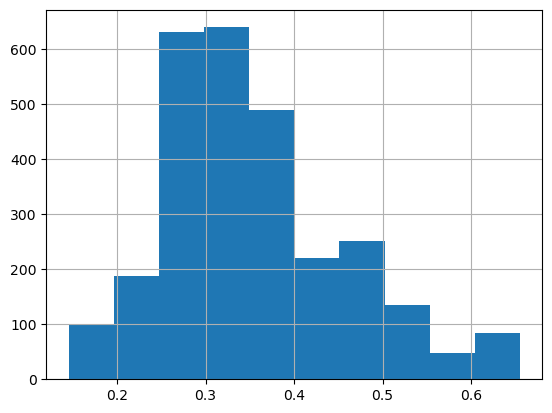

In [73]:
pd.Series(a).hist()